# **Breast Cancer Classification using SVM model**

Loading the Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog

Downloading the Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 195M/195M [00:05<00:00, 37.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1


Loading the Dataset

In [ ]:
#creating a DataFrame with three columns: 1. Image Path, 2. Mask Path, and 3. Label.

path = "/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/"
categories = [['benign',438],['malignant',211],['normal',134]]

images_path_list= []
mask_path_list = []

all_data_path_list = []


for i in range(len(categories)) :

    folder_path = (f'{path}/{categories[i][0]}')

    for j in range(1,categories[i][1]):

        image_path = (f'{folder_path}/{categories[i][0]} ({j}).png')
        mask_path = (f'{folder_path}/{categories[i][0]} ({j})_mask.png')

        images_path_list.append(image_path)
        mask_path_list.append(mask_path)

    data_path_df = pd.DataFrame()

    data_path_df['Image-Path'] =   images_path_list
    data_path_df['Mask-Path'] = mask_path_list
    data_path_df['Label'] = categories[i][0]

    all_data_path_list.append(data_path_df)

    images_path_list = []
    mask_path_list = []

data_path_df = pd.concat(all_data_path_list,axis = 0)
data_path_df.reset_index(drop=True,inplace=True)

data_path_df

,Image-Path,Mask-Path,Label
0,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,benign
1,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,benign
2,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,benign
3,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,benign
4,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,benign
...,...,...,...
775,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,normal
776,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,normal
777,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,normal
778,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,normal


Preprocessing

In [ ]:
#shuffling the dataset due to data imbalance
benign_df = data_path_df.iloc[0:133,:]

malignant_df = data_path_df.iloc[437:646,:]

normal_df = data_path_df.iloc[647:780,:]

shuffled_benign_df = benign_df.sample(133)

shuffled_malignant_df = malignant_df.sample(133)

final_df = pd.concat([shuffled_benign_df,shuffled_malignant_df,normal_df],axis=0)

final_df.reset_index(drop=True,inplace=True)

final_df

map_dic = {'benign':0,'malignant':1,'normal':2}
final_df.replace(map_dic,inplace=True)

final_df['Label'].value_counts()

<ipython-input-5-5fb8f0b1a79e>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df.replace(map_dic,inplace=True)


,count
Label,
0,133
1,133
2,133


In [ ]:
final_df = final_df.sample(frac=1)

final_df.reset_index(inplace = True,drop = True)

final_df

,Image-Path,Mask-Path,Label
0,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,2
1,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,0
2,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,1
3,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,1
4,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,2
...,...,...,...
394,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,2
395,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,2
396,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,1
397,/root/.cache/kagglehub/datasets/aryashah2k/bre...,/root/.cache/kagglehub/datasets/aryashah2k/bre...,0


defining functions for reading the images and masks

In [ ]:
def load_images_and_mask(image_path,mask_path,target_size = (400,400)) :

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image,target_size)
    mask = cv2.resize(mask,target_size)

    return image,mask

def load_images_NormalImage(image_path, target_size=(400, 400)):
    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image path does not exist: {image_path}")
        return None

    image = cv2.imread(image_path)

    # Check if image is loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    # Resize the image if loaded correctly
    image = cv2.resize(image, target_size)

    return image


    return image
def hog_extractor(image,mask) :

    masked_image = cv2.bitwise_and(image,image,mask=mask)

    gray_image = cv2.cvtColor(masked_image,cv2.COLOR_BGR2GRAY)

    features,hot_image = hog(gray_image,pixels_per_cell=(16,16),cells_per_block=(2,2),visualize=True)

    return features

def hog_extractor_NormalImage(image) :

    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    features,hot_image = hog(gray_image,pixels_per_cell=(16,16),cells_per_block=(2,2),visualize=True)

    return features

to double check the path!!

In [ ]:
image_path = final_df.loc[0, 'Image-Path']
print(f"Checking if this image exists: {image_path}")

Checking if this image exists: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//malignant/malignant (181).png


In [ ]:
!ls /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/

benign	malignant  normal


In [ ]:
from PIL import Image

# Try to open the image with Pillow to check if it works
try:
    pil_image = Image.open(image_path)
    pil_image.show()  # This will display the image
    print(f"Image loaded successfully using Pillow: {image_path}")
except Exception as e:
    print(f"Error opening image with Pillow: {e}")

Image loaded successfully using Pillow: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//malignant/malignant (181).png


preparing the dataset

In [ ]:
X = []
Y = []

for rows in range(len(final_df)):
    image_path = final_df.loc[rows, 'Image-Path']

    # Check if the image is loaded properly
    print(f"Processing: {image_path}")

    # Load the normal image
    image = load_images_NormalImage(image_path=image_path)

    # Skip processing if the image is None
    if image is None:
        continue

    try:
        # Extract HOG features
        features = hog_extractor_NormalImage(image)
        if len(features) == 0:
            print(f"Skipping row {rows} because no features were extracted.")
            continue

        X.append(features)
        Y.append(final_df.loc[rows, 'Label'])

    except Exception as e:
        print(f"Error processing row {rows}: {e}")
        continue

print(f"Length of X after loop: {len(X)}")
print(f"Length of Y after loop: {len(Y)}")

if len(X) > 0 and len(Y) > 0:
    X = np.array(X)
    Y = np.array(Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
else:
    print("No valid data to split. Please check the data processing.")


Processing: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//normal/normal (79).png
Processing: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//benign/benign (113).png
Processing: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//malignant/malignant (180).png
Processing: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//malignant/malignant (204).png
Processing: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//normal/normal (63).png
Processing: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT//malignant/malignant (36).png
Processing: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_wit

In [ ]:
def evaluate(Y_prediction,name):

    report = classification_report(y_true=Y_test,y_pred=Y_prediction)

    print(report)

    print('\n---------------------------------------------------------------------------------------------------------------\n')

    conf_matrix = confusion_matrix(y_true=Y_test,y_pred=Y_prediction)

    plt.figure(figsize=(8,5))

    sns.heatmap(conf_matrix,annot=True,cmap='Blues')

    plt.xlabel('Predicted Label')

    plt.ylabel('True Label')

    plt.title(f'{name} Evaluation')

    plt.show()

**training the SVM model without feature extraction with cnn**


The best parameters are: {'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


The train accuracy is: 0.6960685483870968


The test accuracy is: 0.7125

              precision    recall  f1-score   support

           0       0.76      0.48      0.59        27
           1       0.68      0.78      0.72        27
           2       0.72      0.88      0.79        26

    accuracy                           0.71        80
   macro avg       0.72      0.71      0.70        80
weighted avg       0.72      0.71      0.70        80


---------------------------------------------------------------------------------------------------------------



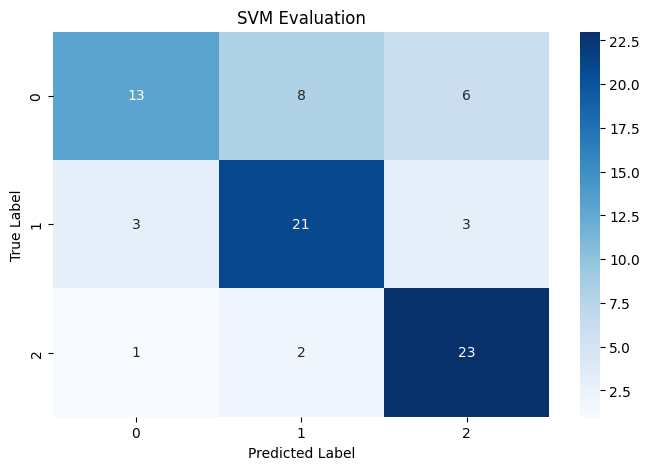

In [ ]:
def SVM():
    grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 5],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1]
    }

    SVM_Model = SVC()


    SVM_CV = GridSearchCV(estimator=SVM_Model, param_grid=grid, cv=10, n_jobs=-1)

    # Fit the model
    SVM_CV.fit(X_train, Y_train.ravel())

    print(f'\nThe best parameters are: {SVM_CV.best_params_}\n')
    print(f'\nThe train accuracy is: {SVM_CV.best_score_}\n')
    print(f'\nThe test accuracy is: {SVM_CV.score(X_test, Y_test)}\n')

    return SVM_CV.best_estimator_

# Get the best SVM model after tuning
SVM_Model = SVM()

# Make predictions
Y_prediction_SVM = SVM_Model.predict(X_test)

# Evaluate the model
evaluate(Y_prediction=Y_prediction_SVM, name='SVM')


**training the SVM model with featire extraction using CNN**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Prepare X and Y arrays for features and labels
X = []
Y = []

#extract features
for index, row in final_df.iterrows():
    image_path = row['Image-Path']
    label = row['Label']

    processed_image = preprocess_image(image_path)
    features = feature_extractor.predict(processed_image)
    features_flat = features.flatten()

    X.append(features_flat)
    Y.append(label)


X = np.array(X)
Y = np.array(Y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)


X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
grid_search.fit(X_train_pca , Y_train)

# Best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Evaluate the best model
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test_pca)
print(classification_report(Y_test, Y_pred))






58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        32
           1       0.79      0.79      0.79        29
           2       0.74      0.89      0.81        19

    accuracy                           0.80        80
   macro avg       0.80      0.81      0.80        80
weighted avg       0.81      0.80      0.80        80


---------------------------------------------------------------------------------------------------------------



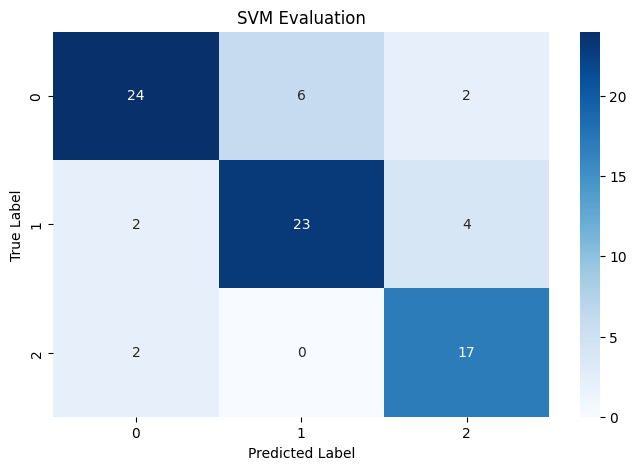

In [ ]:
# Evaluate the model
evaluate(Y_prediction=Y_pred, name='SVM')

Enhanced Acuuracy

In [17]:
#PCA NOFINE TUNE
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Preprocessing function for images
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

X = []
Y = []

# Extract features using the VGG16 base model (excluding top layers)
for index, row in final_df.iterrows():
    image_path = row['Image-Path']
    label = row['Label']

    processed_image = preprocess_image(image_path)

    # Extract features using VGG16
    features = base_model.predict(processed_image)


    features_flat = features.flatten()

    X.append(features_flat)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X)


X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)

# SVM Hyperparameter tuning using GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
grid_search.fit(X_train, Y_train)


print(f'Best Parameters: {grid_search.best_params_}')

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
print(classification_report(Y_test, Y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In [23]:
#randomized search cv
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Preprocessing function for images
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


X = []
Y = []

# Extract features using the VGG16 base model
for index, row in final_df.iterrows():
    image_path = row['Image-Path']
    label = row['Label']


    processed_image = preprocess_image(image_path)

    # Extract features using VGG16
    features = base_model.predict(processed_image)


    features_flat = features.flatten()

    X.append(features_flat)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X)

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': uniform(0.01, 10),
    'gamma': uniform(0.01, 1),
    'kernel': ['rbf', 'linear']
}

# Perform RandomizedSearchCV with SVM and hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=SVC(class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Run the RandomizedSearchCV on the training data
print("Running Randomized Search for SVM...")
random_search.fit(X_train, Y_train)

# Best parameters found by RandomizedSearchCV
print(f'Best Parameters: {random_search.best_params_}')

# Evaluate the best model
best_model = random_search.best_estimator_
Y_pred = best_model.predict(X_test)
print(classification_report(Y_test, Y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        20
           1       0.89      0.77      0.83        31
           2       0.81      0.86      0.83        29

    accuracy                           0.84        80
   macro avg       0.84      0.85      0.84        80
weighted avg       0.84      0.84      0.84        80


---------------------------------------------------------------------------------------------------------------



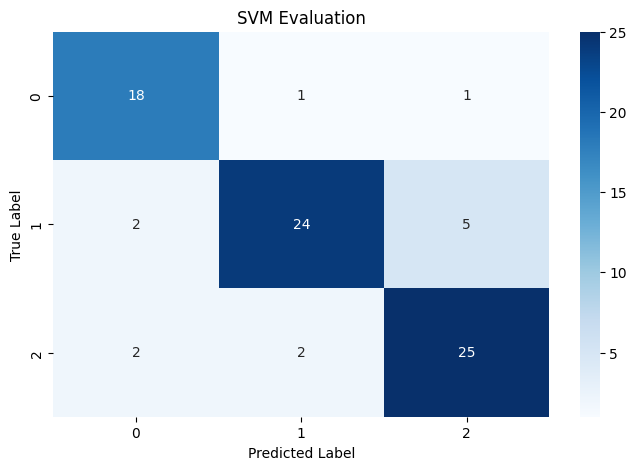

In [24]:
# Evaluate the model
evaluate(Y_prediction=Y_pred, name='SVM')

In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Preprocessing
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

X = []
Y = []

# Extract features using the VGG16 base model
for index, row in final_df.iterrows():
    image_path = row['Image-Path']
    label = row['Label']

    processed_image = preprocess_image(image_path)

    # Extract features using VGG16
    features = base_model.predict(processed_image)

    features_flat = features.flatten()

    X.append(features_flat)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X)


X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'C': uniform(0.01, 10),  #
    'gamma': uniform(0.01, 1),  # Kernel coefficient for 'rbf'
    'kernel': ['rbf', 'linear'],  # Kernel type: 'rbf' or 'linear'
    'class_weight': ['balanced', None]  # To handle class imbalance
}


svm_classifier = SVC(random_state=42)

# Perform RandomizedSearchCV with SVM and PCA-reduced features
random_search = RandomizedSearchCV(
    estimator=svm_classifier,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Run the RandomizedSearchCV on the training data
print("Running Randomized Search for SVM...")
random_search.fit(X_train, Y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"\nBest Parameters: {best_params}")
print(f"Cross-Validation Accuracy: {random_search.best_score_:.4f}")

test_accuracy = best_model.score(X_test, Y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

Y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

print("\nAccuracy:", accuracy_score(Y_test, Y_pred))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━